## Predicting the price for an Airbnb Host in Milan

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year.

In Italy, no city is more popular than Milan for tech industry as well as  for tourism industry. That implies that Milan is one of the hottest markets for Airbnb in Europe, with over 18,783 listings as of August 2020. With a size of 181.8 km², this means there are roughly 104 homes being rented out per km² in Berlin on Airbnb!

Considering the possibility that I might have to relocate for a new data science job, but want to keep my current flate (which is quite cheap!), I might wonder if it could be worth it to offer my jewel on Airbnb. Could this perhaps be a profitable option? However, it is difficult for potential hosts to know what the true value of their home is, and how in-demand their home might be. And since location and furniture are obviously fixed for the most part, is there anything else a host can influence - such as description, communication patterns, and/or additional services to boost their earnings?

The following question will drive this project:<br>
> **Can we determine a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Milan?** <br>

The question focuses on the accommodation features and decisions a new host can make with regards to initial presentation, i.e. posting a picture of him- or herself on the website, determining a minimum length of stay, offering instant bookings etc. A machine learning algorithm will be applied to try to get an answer. 

### The dataset

In the first notebook, I will perform an analysis of the detailed Milan listings data, sourced from the Inside Airbnb website, in order to understand the rental landscape and try to recommend a price for a newbie entering the market. The dataset is named `listings.csv.gz` and was scraped on September 02nd 2020.

### 1. Obtaining and Viewing the Data 


In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_initial = pd.read_csv('C:/Users/Ankit Patel/Documents/GitHub/Milan Airbnb Prediction/dataset/listings_summary.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 18783 rows and 16 columns.
It contains 0 duplicates.


In [3]:
df_initial.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6400,The Studio Milan,13822,Francesca,NaN,TIBALDI,45.44195,9.17797,Private room,100,4,12,2019-04-13,0.10,1,358
1,23986,""" Characteristic Milanese flat""",95941,Jeremy,NaN,NAVIGLI,45.44991,9.17597,Entire home/apt,150,1,14,2019-09-02,0.14,1,359
2,32119,Nico & Cynthia's Easy Yellow Suite,138683,Nico&Cinzia,NaN,VIALE MONZA,45.51988,9.22310,Entire home/apt,107,3,15,2018-07-01,0.12,4,364
3,32649,Nico&Cinzia's Red Easy Suite!,138683,Nico&Cinzia,NaN,VIALE MONZA,45.51942,9.22615,Entire home/apt,72,3,29,2019-07-07,0.24,4,364
4,37256,COZY FULLY FURNISHED PRIVATE STUDIO CITY CENTER,119002,Giancarlo,NaN,GUASTALLA,45.47074,9.20578,Private room,55,2,34,2019-11-03,0.29,2,328


In [4]:
# check the columns we currently have
df_initial.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

### 2. Preprocessing the Data
#### 2.1. Deciding which columns to work with
Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'name', 'host_id', 'host_name', 
                   'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 18783 rows and 14 columns - after dropping irrelevant columns.


By the way, how many different **room types** do we have?

In [6]:
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.746579
Private room       0.231592
Shared room        0.016132
Hotel room         0.005697
Name: room_type, dtype: float64

By the way, how many different **neighberhood** do we have?

In [7]:
df_raw.neighbourhood.value_counts(normalize=True)

BUENOS AIRES - VENEZIA    0.077730
DUOMO                     0.051589
NAVIGLI                   0.047437
SARPI                     0.044082
TICINESE                  0.040941
                            ...   
PARCO NORD                0.000160
PARCO AGRICOLO SUD        0.000053
STEPHENSON                0.000053
RONCHETTO DELLE RANE      0.000053
QUINTOSOLE                0.000053
Name: neighbourhood, Length: 87, dtype: float64

#### 2.2. Cleaning Columns

In [8]:
df_raw['price'].head()

id
6400     100
23986    150
32119    107
32649     72
37256     55
Name: price, dtype: int64

Let's first check if there are any null values in the `price` column:

In [9]:
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

No, so we don't need to drop any rows.

In [10]:
df_raw['price'].describe()

count    18783.000000
mean       112.951286
std        300.991697
min          8.000000
25%         50.000000
50%         73.000000
75%        110.000000
max      11164.000000
Name: price, dtype: float64

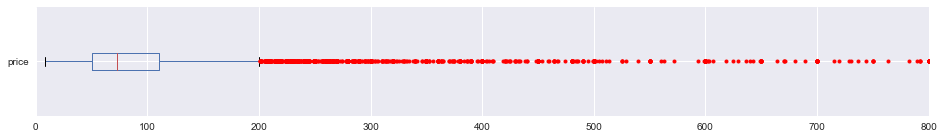

In [11]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 800), vert=False, flierprops=red_square, figsize=(16,2));

A bit messy, as expected! 

75% of the apartments charge up to 112€ - but the maximum value is 11164€. Let's decide on a limit of 300€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [12]:
df_raw.drop(df_raw[ (df_raw.price > 300) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [13]:
df_raw['price'].describe()

count    18099.000000
mean        87.720537
std         55.863608
min          8.000000
25%         50.000000
50%         70.000000
75%        101.000000
max        300.000000
Name: price, dtype: float64

In [14]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 18099 rows and 14 columns - after being price-wise preprocessed.


#### 2.3. Dealing with Missing Values

In [15]:
df_raw.isna().sum()

name                                11
host_id                              0
host_name                            1
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       4172
reviews_per_month                 4172
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [16]:
# drop columns with too many Nan's
df_raw.drop(columns=['last_review', 'reviews_per_month'], inplace=True)

In [17]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['name', 'host_name', ], inplace=True)

In [18]:
df_raw.isna().sum()

name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [19]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 18087 rows and 12 columns - after having dealt with missing values.


#### 2.4. Feature Engineering 1: Distance to Centroid (Central railway station) of Milan



Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called centroid of Milan instead of just relying on the neighbourhoods or areas. 

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

In [20]:
from geopy.distance import great_circle

In [21]:
def distance_to_mid(lat, lon):
    milan_centre = ( 45.4850, 9.2022)
    accommodation = (lat, lon)
    return great_circle(milan_centre, accommodation).km

In [22]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [23]:
df_raw.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,distance
id,,,,,,,,,,,,,
6400,The Studio Milan,13822,Francesca,TIBALDI,45.44195,9.17797,Private room,100,4,12,1,358,5.146423
23986,""" Characteristic Milanese flat""",95941,Jeremy,NAVIGLI,45.44991,9.17597,Entire home/apt,150,1,14,1,359,4.405489
32119,Nico & Cynthia's Easy Yellow Suite,138683,Nico&Cinzia,VIALE MONZA,45.51988,9.22310,Entire home/apt,107,3,15,4,364,4.206628
32649,Nico&Cinzia's Red Easy Suite!,138683,Nico&Cinzia,VIALE MONZA,45.51942,9.22615,Entire home/apt,72,3,29,4,364,4.258220
37256,COZY FULLY FURNISHED PRIVATE STUDIO CITY CENTER,119002,Giancarlo,GUASTALLA,45.47074,9.20578,Private room,55,2,34,2,328,1.610022
